#Step 4 
Optimization with uncertain conversion rates, 𝛼 ratios, and number of items sold per product

In [14]:
import copy

import numpy as np
import matplotlib.pyplot as plt


import Code.utils as utils
import Code.environment.settings as settings
from Code.environment.Environment import Environment
from Code.GreedyLearner import GreedyLearner
from Code.environment.Customer import Customer
from Code.UCBLearner import UCBLearner
from Code.TSLearner import TSLearner
from Code.UCBLearner4 import UCBLearner4
from Code.TSLearner4 import TSLearner4

%matplotlib inline

In [15]:
cust_json = "customer_classes.json"
today_customer = 50
var_cust = 0
p_lambda = 1.0
graph_json = "business_full_graph.json"

arms = settings.prices
environment = Environment(cust_json,today_customer,var_cust,p_lambda, graph_json, arms)
clairvoyant_arms, clairvoyant_reward, exp_c, rew_per_arm= environment.estimate_clairvoyant()
print("\n", clairvoyant_arms, clairvoyant_reward, exp_c, rew_per_arm.values())

loading: [==============================] 99.6%
 [3, 2, 3, 1, 0] 1488.8172801920002 29.776345603840003 dict_values([257.792311324, 176.61328192500002, 259.780779124, 208.38750341000002, 305.28078984600006, 216.03804272700003, 306.965331681, 248.585585021, 276.96868681600006, 195.74717445700003, 278.29476912399997, 225.34594765800003, 308.47159482800004, 228.12540927300003, 310.08475810100003, 257.73853212100005, 318.50568366400006, 235.0401024855, 319.767797692, 268.53187241300003, 371.406151147, 279.01736869449996, 372.20153456649996, 313.44263588250004, 342.5584052880001, 258.4881406415, 342.94393584000005, 289.91988134100006, 376.05270729800003, 293.1680813955, 376.8078626165, 324.45436001649995, 272.81103478800003, 190.79104065500002, 274.38322826100006, 221.866072093, 321.19020717100005, 231.03403011100005, 322.47596781950006, 263.0340090925, 291.38708512000005, 209.571188493, 292.40425392500003, 238.73242063700002, 324.58782121600007, 243.53425362600004, 325.83181684950006, 272.5

In [16]:
n_arms = 4
n_products = 5 

feature1 = 0
feature2 = 0

customer = Customer(feature1, feature2)

TIME_HORIZON = 300
NUM_ITERATION = 1

In [17]:
#unknown parameters
alphas = np.array([0.2, 0.2, 0.2, 0.2, 0.2]) #uniform
prods_dist = np.ones((n_products,n_arms))   #all 1

customers = copy.deepcopy(environment.customers)

for customer in customers:
    customer.set_distribution_alpha(alphas)
    customer.set_num_prods(prods_dist)

UCB

In [18]:
rewards_iterations = []
for i in range(NUM_ITERATION):
    ucb4_learner = UCBLearner4(n_arms, n_products, customers, graph_json, arms, environment.customers_distribution, debug=True)
    print('Iteration #', i+1)
    for t in range(TIME_HORIZON):
        if t % 10 == 0:
            utils.progress_bar(t, TIME_HORIZON)
        super_arm = ucb4_learner.select_superarm()
        report = environment.round(super_arm)
        ucb4_learner.update(super_arm.copy(), report)
    rewards = ucb4_learner.history_rewards
    rewards_iterations.append(np.array(rewards))
rewards_iterations = np.array(rewards_iterations)
rewards_iterations.shape

Iteration # 1
loading: [                              ] 0.0%customer alpha: [0.2 0.2 0.2 0.2 0.2]
customer alpha: [0.42 0.16 0.24 0.02 0.16]
customer alpha: [0.38 0.23 0.18 0.04 0.17]
customer alpha: [0.43333333 0.21333333 0.12666667 0.05333333 0.17333333]
customer alpha: [0.45  0.195 0.135 0.055 0.165]
customer alpha: [0.428 0.216 0.14  0.06  0.156]
customer alpha: [0.42333333 0.20333333 0.13333333 0.07666667 0.16333333]
customer alpha: [0.41142857 0.19714286 0.14285714 0.07428571 0.17428571]
customer alpha: [0.4025 0.2125 0.145  0.07   0.17  ]
customer alpha: [0.40222222 0.21333333 0.14222222 0.07333333 0.16888889]
loading: [=                             ] 3.3%customer alpha: [0.402 0.222 0.134 0.074 0.168]
customer alpha: [0.39636364 0.21454545 0.14       0.07454545 0.17454545]
customer alpha: [0.4        0.21166667 0.13666667 0.07666667 0.175     ]
customer alpha: [0.39076923 0.20923077 0.13692308 0.08153846 0.18153846]
customer alpha: [0.38714286 0.20857143 0.14142857 0.08285714 0

(1, 300)

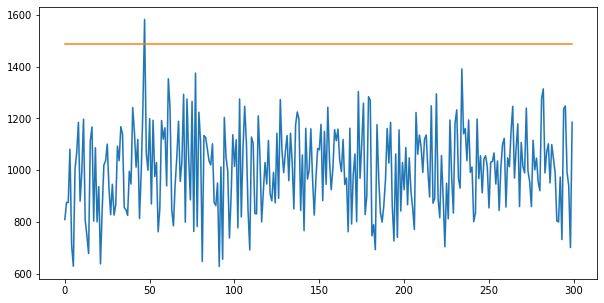

In [19]:
plt.figure(figsize=(10, 5))
mean = np.mean(rewards_iterations, axis=0)
stdev = np.std(rewards_iterations, axis=0)

plt.plot(range(len(mean)), mean)
plt.fill_between(range(len(mean)), (mean-stdev), (mean+stdev), color='b', alpha=.1)

plt.plot([_ for _ in range(len(rewards))], [clairvoyant_reward for _ in range(len(rewards))])
plt.show()

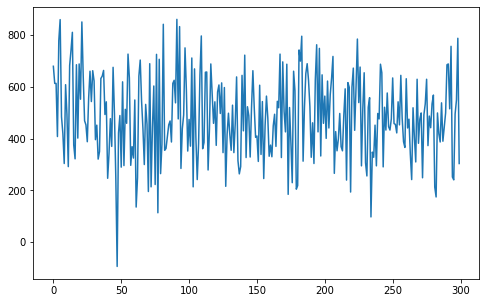

In [20]:
plt.figure(figsize=(8,5))
regret = clairvoyant_reward - rewards_iterations 
mean_regret = np.mean(regret, axis=0)

plt.plot(range(len(mean_regret)), mean_regret)
plt.show()

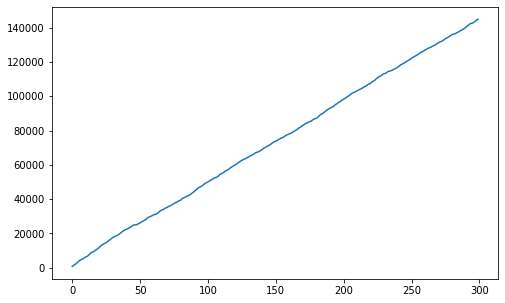

In [21]:
plt.figure(figsize=(8,5))
regret = clairvoyant_reward - rewards_iterations 
cumulative_regret = np.cumsum(regret, axis=1)
cum_reg_mean = np.mean(cumulative_regret, axis=0)

plt.plot(range(len(cum_reg_mean)), cum_reg_mean)
plt.show()

TS

In [22]:
rewards_iterations = []
for i in range(NUM_ITERATION):
    ts_learner4 = TSLearner4(n_arms, n_products, customers, graph_json, arms, environment.customers_distribution, debug=True)
    print('\nIteration #', i+1)
    for t in range(TIME_HORIZON):
        if t % 10 == 0:
            utils.progress_bar(t, TIME_HORIZON)
        super_arm = ts_learner4.select_superarm()
        report = environment.round(super_arm)
        ts_learner4.update(super_arm.copy(), report)
    rewards = ts_learner4.history_rewards
    rewards_iterations.append(np.array(rewards))
rewards_iterations = np.array(rewards_iterations)
rewards_iterations.shape


Iteration # 1
loading: [============================= ] 96.7%

(1, 300)

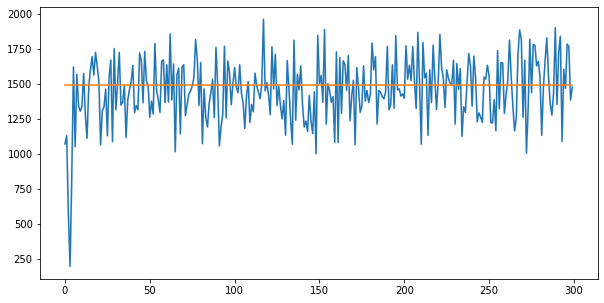

In [23]:
plt.figure(figsize=(10, 5))
mean = np.mean(rewards_iterations, axis=0)
stdev = np.std(rewards_iterations, axis=0)

plt.plot(range(len(mean)), mean)
plt.fill_between(range(len(mean)), (mean-stdev), (mean+stdev), color='b', alpha=.1)

plt.plot([_ for _ in range(len(rewards))], [clairvoyant_reward for _ in range(len(rewards))])
plt.show()

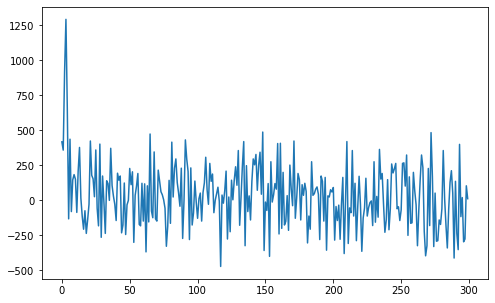

In [24]:
plt.figure(figsize=(8,5))
regret = clairvoyant_reward - rewards_iterations 
mean_regret = np.mean(regret, axis=0)

plt.plot(range(len(mean_regret)), mean_regret)
plt.show()

In [25]:
a = np.mean(regret[:,200:], axis=0)
np.shape(a)
print(np.mean(a))

-18.182719807999774


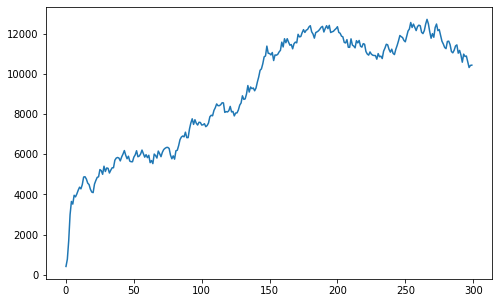

In [26]:
plt.figure(figsize=(8,5))
regret = clairvoyant_reward - rewards_iterations 
cumulative_regret = np.cumsum(regret, axis=1)
cum_reg_mean = np.mean(cumulative_regret, axis=0)

plt.plot(range(len(cum_reg_mean)), cum_reg_mean)
plt.show()